In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pytorch_wavelets as pw
from torch.nn.modules.utils import _pair, _quadruple
import pywt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
#from online: the mean of MNIST is 0.1307, the std 0.3081
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

trainset = torchvision.datasets.MNIST(root= '../data', train=True,
                                        download=True, transform=transform)
#keep batches in 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

## Attempted Wavelets:

Haar: Fully Connected 1(9216, 128)
Daubechies 1: Fully Connected 1 (9216,128)
Daubechies 2: Fully Connected 2(7744, 128)

In [59]:
import torch
import torch.nn as nn
import numpy as np

def get_wav(in_channels,  pool=True):
    """wavelet decomposition using conv2d"""
    
    w = pywt.Wavelet('db2')
    
    dec_hi = torch.Tensor(w.dec_hi[::-1]) 
    dec_lo = torch.Tensor(w.dec_lo[::-1])
    rec_hi = torch.Tensor(w.rec_hi)
    rec_lo = torch.Tensor(w.rec_lo)
    
    filter_LL = dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_LH = dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1)
    filter_HL = dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1)
    filter_HH = dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
 
    if pool:
        model = nn.Conv2d
    else:
        model = nn.ConvTranspose2d

    LL = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    LH = model(in_channels, in_channels,
             kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HL = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)
    HH = model(in_channels, in_channels,kernel_size=2, stride=2, padding=0, bias=False,
             groups=in_channels)

    LL.weight.requires_grad = False
    LH.weight.requires_grad = False
    HL.weight.requires_grad = False
    HH.weight.requires_grad = False

    LL.weight.data = filter_LL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    LH.weight.data = filter_LH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HL.weight.data = filter_HL.float().unsqueeze(0).expand(in_channels, -1, -1, -1)
    HH.weight.data = filter_HH.float().unsqueeze(0).expand(in_channels, -1, -1, -1)

    return LL, LH, HL, HH

class WavePool(nn.Module):
    def __init__(self,in_channels):
        super(WavePool,self).__init__()
        self.LL,self.LH,self.HL,self.HH = get_wav(in_channels)

    def forward(self,x):
        return self.LL(x)

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(7744, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = WavePool(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [60]:
net = Net()
train_loss = []
run_loss = []
test_loss = []
test_accuracy = []

#loss function: Log Loss
criterion = nn.CrossEntropyLoss()
#stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(10):  # loop/over the dataset multiple times
    training_loss = 0
    running_loss = 0.0
    num_images = 0

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        num_images += inputs.size(1)
        # print statistics
        running_loss += loss.item()
        training_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] running loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_images))
            run_loss.append(running_loss / num_images)
            running_loss = 0.0
    train_loss.append(training_loss / num_images)

    testing_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in testloader:
            output = net(data)
            testing_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    
    test_loss.append(testing_loss / len(testloader.dataset))
    test_accuracy.append(correct/ len(testloader.dataset))
    
    print('Epoch %d, Training Loss:  %.3f, Testing Loss: %.3f, Testing Accuracy: %.3f' %
         (epoch + 1, training_loss / num_images, testing_loss / len(testloader.dataset), correct/ len(testloader.dataset))) 

print('Finished Training')

[1,  1000] running loss: 0.979
[1,  2000] running loss: 0.226
[1,  3000] running loss: 0.112
[1,  4000] running loss: 0.066
[1,  5000] running loss: 0.047
[1,  6000] running loss: 0.035
[1,  7000] running loss: 0.026
[1,  8000] running loss: 0.024
[1,  9000] running loss: 0.020
[1, 10000] running loss: 0.018
[1, 11000] running loss: 0.013
[1, 12000] running loss: 0.011
[1, 13000] running loss: 0.011
[1, 14000] running loss: 0.010
[1, 15000] running loss: 0.007
Epoch 1, Training Loss:  0.258, Testing Loss: 0.119, Testing Accuracy: 0.965
[2,  1000] running loss: 0.146
[2,  2000] running loss: 0.059
[2,  3000] running loss: 0.038
[2,  4000] running loss: 0.030
[2,  5000] running loss: 0.021
[2,  6000] running loss: 0.016
[2,  7000] running loss: 0.013
[2,  8000] running loss: 0.014
[2,  9000] running loss: 0.013
[2, 10000] running loss: 0.009
[2, 11000] running loss: 0.008
[2, 12000] running loss: 0.009
[2, 13000] running loss: 0.008
[2, 14000] running loss: 0.006
[2, 15000] running loss:

Text(0, 0.5, 'Error')

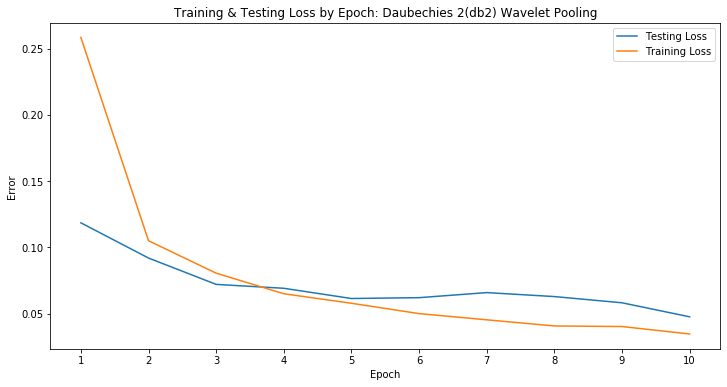

In [61]:
plt.figure(figsize =(12,6))
plt.plot(np.arange(1,11, step=1), test_loss, label = 'Testing Loss')
plt.plot(np.arange(1, 11, step=1), train_loss, label = 'Training Loss')
plt.title('Training & Testing Loss by Epoch: Daubechies 2(db2) Wavelet Pooling')
plt.xticks(np.arange(1,11, step=1))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')

In [62]:
train_loss

[0.25844028755215337,
 0.10498472086957883,
 0.08052205435670082,
 0.06498882349452033,
 0.05780183808535634,
 0.04999507590333173,
 0.0453135074753294,
 0.04067532676093158,
 0.04023091798703311,
 0.03462005581594449]

In [63]:
test_loss

[0.11851888873445696,
 0.09193535937033376,
 0.07205479149741627,
 0.06910987375976556,
 0.06139004595393259,
 0.06202518326745363,
 0.06584982891033507,
 0.06285830447700955,
 0.05816200564314954,
 0.04758035167107423]

In [64]:
run_loss

[0.9793515340820886,
 0.22564912821460165,
 0.11220725678368278,
 0.06645620135875106,
 0.047469269817553866,
 0.03450893398206578,
 0.02647174557137519,
 0.0235918636128697,
 0.01979982669075899,
 0.017552941909827403,
 0.013121995356558997,
 0.011200390461591832,
 0.011120927270794377,
 0.009938828504375578,
 0.007258714582951105,
 0.1455136323357101,
 0.0591116449921613,
 0.037835243191392844,
 0.0299204998936968,
 0.02131014257197828,
 0.01632122948156975,
 0.012942620442874584,
 0.014451074519676296,
 0.01266809008793507,
 0.009026600420919281,
 0.008336854338005304,
 0.008601204357892736,
 0.007812986243225758,
 0.00551111417980545,
 0.005949203191683368,
 0.09000780422480913,
 0.04078746672800733,
 0.03223865506784676,
 0.019821564649314737,
 0.016662514676784475,
 0.012947318262341297,
 0.010601431381550567,
 0.00921699018342924,
 0.009633171150164158,
 0.007839288879599587,
 0.0072514213512789635,
 0.007565852621153065,
 0.0047657113462027155,
 0.0057609170752958285,
 0.004869

In [34]:
pywt.cwt(np.ones((2,2)),'mexh')

TypeError: cwt() missing 1 required positional argument: 'wavelet'

pywt._extensions._pywt.ContinuousWavelet(name='shan1.5-1.0')